# 03 - Sequence Model Approach

* The more 'classical' approach to solving this problem
* Train a model that can take any number of 'steps'
* Makes a prediction on next step based on previous steps
* Learn from full tracks
* For test tracks, predict what the next step's values will be

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout, ReLU, GRU, TimeDistributed, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from jlab import load_test_data, get_test_detector_plane

## Load up and prep the datasets

In [3]:
X_train = pd.read_csv('MLchallenge2_training.csv')
X_test = load_test_data('test_in.csv')
eval_planes = get_test_detector_plane(X_test)

# Also, load our truth values
y_true = pd.read_csv('test_prediction.csv', names=['x', 'y', 'px', 'py', 'pz'],
                     header=None)

In [4]:
X_test.head()

,x,y,z,px,py,pz,x1,y1,z1,px1,...,z23,px23,py23,pz23,x24,y24,z24,px24,py24,pz24
0,0.877,1.322,65.0,-0.244,-0.053,2.414,-10.669,0.330,176.944,-0.254,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.786,-2.483,65.0,0.103,0.432,2.593,7.366,15.502,176.944,0.206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-13.134,-26.531,65.0,0.064,-0.021,0.953,-7.586,-30.687,176.944,0.027,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18.454,2.805,65.0,-0.019,0.069,1.833,18.043,6.797,176.944,0.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.552,-19.196,65.0,-0.010,-0.011,2.366,15.068,-19.750,176.944,-0.014,...,341.28,-0.014,-0.002,2.351,NaN,NaN,343.405,NaN,NaN,NaN


In [5]:
y_true.head()

,x,y,px,py,pz
0,-23.123945,3.142886,-0.235592,0.091612,2.413377
1,19.633486,32.319292,0.314376,0.316425,2.592952
2,-8.308506,-39.299613,-0.020097,-0.051232,0.948906
3,19.918838,10.664617,0.038102,0.047740,1.864014
4,13.649239,-20.616935,-0.015548,0.001471,2.323953


## Construct the training data and targets

* For each track
  * Choose a number N between 8 and 24
  * That track will have 6 kinematics for N blocks
  * The target variable will be the 6 kinematic variables for the N+1th detector block
* This will cause variable length sequences
* Apply `pad_sequences` to prepend with zeros appropriately

### Training Dataset

In [10]:
N_SAMPLES = len(X_train)
N_DETECTORS = 25
N_KINEMATICS = 6
SHAPE = (N_SAMPLES, N_DETECTORS-1, N_KINEMATICS)

In [11]:
X_train_list = []
y_train_array = np.ndarray(shape=(N_SAMPLES, N_KINEMATICS-1))
for ix in range(N_SAMPLES):
    seq_len = np.random.choice(range(8, 25))
    track = X_train.iloc[ix].values.reshape(N_DETECTORS, N_KINEMATICS)
    X_train_list.append(track[0:seq_len])
    # Store the kinematics of the next in the sequence
    # Ignore the 3rd one, which is z
    y_train_array[ix] = track[seq_len][[0,1,3,4,5]]

In [12]:
for track in X_train_list[:10]:
    print(len(track))

12
17
16
22
9
11
13
22
24
17


In [13]:
X_train_list = pad_sequences(X_train_list, dtype=float)

In [14]:
for track in X_train_list[:10]:
    print(len(track))

24
24
24
24
24
24
24
24
24
24


In [15]:
X_train_array = np.array(X_train_list)
X_train_array.shape

(194601, 24, 6)

In [16]:
y_train_array.shape

(194601, 5)

### Validation Dataset

In [17]:
N_TEST_SAMPLES = len(X_test)

In [18]:
y_test_array = y_true.values

In [19]:
X_test_list = []
for ix in range(N_TEST_SAMPLES):
    seq_len = get_test_detector_plane(X_test.iloc[ix])
    track = X_test.iloc[ix].values.reshape(N_DETECTORS, N_KINEMATICS)
    X_test_list.append(track[0:seq_len])

In [20]:
X_test_list = pad_sequences(X_test_list, dtype=float)
X_test_array = np.array(X_test_list)

In [21]:
X_test_array.shape

(10000, 24, 6)

In [22]:
y_test_array.shape

(10000, 5)

In [23]:
y_true.values.shape

(10000, 5)

In [1]:
import pandas as pd
import numpy as np
from math import floor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('MLchallenge2_training.csv')

In [4]:
# Z values are constant -- what are they?
Z_VALS = data[['z'] + [f'z{i}' for i in range(1, 25)]].loc[0].values
# Z-distance from one timestep to another is set; calculate it
Z_DIST = [Z_VALS[i+1] - Z_VALS[i] for i in range(0, 24)] + [0.0]

In [18]:
# Number of timesteps
N_DETECTORS = 25
# Provided number of kinematics
N_KINEMATICS = 6
# Number of features after engineering them all
N_FEATURES = 13

In [4]:
def get_detector_meta(kin_array, det_id):
    
    # Is there a large gap after this detector?
    # 0 is for padded timesteps
    # 1 is for No, 2 is for Yes
    mind_the_gap = int(det_id % 6 == 0) + 1
    
    # Detector group: 1 (origin), 2, 3, 4, or 5
    det_grp = floor((det_id-1) / 6) + 2
    
    # Detectors numbered 1-6 (origin is 6)
    # (Which one in the group of six is it?)
    det_rank = ((det_id-1) % 6) + 1
    
    # Distance to the next detector?
    z_dist = Z_DIST[det_id]
    
    # Transverse momentum (x-y component)
    pt = np.sqrt(np.square(kin_array[3]) + np.square(kin_array[4]))
    
    # Total momentum
    p_tot = np.sqrt(np.square(kin_array[3])
                    + np.square(kin_array[4])
                    + np.square(kin_array[5]))

    # Put all the calculated features together
    det_meta = np.array([det_id, mind_the_gap, det_grp, det_rank,
                         z_dist, pt, p_tot])
    
    # Return detector data plus calculated features
    return np.concatenate([kin_array, det_meta], axis=None)

In [5]:
def tracks_to_time_series(X):
    """Convert training dataframe to multivariate time series training set
    
    Pivots each track to a series ot timesteps. Then randomly truncates them
    to be identical to the provided test set. The step after the truncated
    step is saved as the target.
    
    Truncated sequence are front-padded with zeros.
    
    Parameters
    ----------
    X : pandas.DataFrame
    
    Returns
    -------
    (numpy.ndarray, numpy.ndarray)
        Tuple of the training data and labels
    """
    
    X_ts_list = []
    n_samples = len(X)
    y_array = np.ndarray(shape=(n_samples, N_KINEMATICS-1))
    for ix in range(n_samples):
        # Randomly choose how many detectors the track went through
        track_len = np.random.choice(range(8, 25))
        # Reshape into ts-like
        track = X.iloc[ix].values.reshape(N_DETECTORS, N_KINEMATICS)
        #eng_track = np.zeros(shape=(N_DETECTORS, N_FEATURES))
        #for i in range(0, N_DETECTORS):
        #    eng_track[i] = get_detector_meta(track[i], i)
        # Truncate the track to only N detectors
        X_ts_list.append(track[0:track_len])
        # Store the kinematics of the next in the sequence
        # Ignore the 3rd one, which is z
        y_array[ix] = track[track_len][[0,1,3,4,5]]
        
    # Pad the training sequence
    X_ts_list = pad_sequences(X_ts_list, dtype=float)
    X_ts_array = np.array(X_ts_list)
    
    return X_ts_array, y_array

In [6]:
X, y = tracks_to_time_series(data)

In [7]:
X[3]

array([[ 0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 1.84542e+01,  2.80469e+00,  6.50000e+01, -1.93839e-02,
         6.93840e-02,  1.83259e+00],
       [ 1.80433e+01,  6.79747e+00,  1.76944e+02,  1.30392e-02,
         6.20286e-02,  1.82485e+00],
       [ 1.80588e+01,  6.86968e+00,  1.79069e+02,  1.32902e-02,
         6.19080e-02,  1.82484e+00],
       [ 1.80749e+01,  6.94169e+00,  1.81195e+02,  1.48815e-02,
         6.18535e-02,  1.82481e+00],
       [ 1.80926e+01,  7.01374e+00,  1.83320e+02,  1.53596e-02,
         6.20166e-02,  1.82479e+00],
       [ 1.81105e+01,  7.08585e+00,  1.85445e+02,  1.54059e-02,
         6.18141e-02,  1.82477e+00],
       [ 1.81287e+01,  7.15783e+00,  1.87571e+02,  1.59919e-02,
         6.19073e-02,  1.82469e+00],
       [ 1.86773e+01,  8.71037e+00,  2.35514e+02,  2.58893e-02,
         5.57861e-02,  1.82465e+00],
       [ 1.87077e+01,  8.77517e+00,  2.37639e+02,  2.62399e-02,
         5.55210e-02,  1.82

In [8]:
y[3]

array([20.7233   , 11.6457   ,  0.039513 ,  0.0515839,  1.82412  ])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
len(X_train), len(X_test)

(145950, 48651)

## Multi-layer GRU Model with LReLU

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LeakyReLU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [20]:
def lrelu(x):
    return LeakyReLU()(x)


def gru_model(gru_units=35, dense_units=100,
              dropout_rate=0.25):
    """Model definition.
    
    Three layers of Gated Recurrent Units (GRUs), utilizing
    LeakyReLU activations, finally passing GRU block output
    to a dense layer, passing its output to the final output
    layer, with a touch of dropout in between.
    
    Bon apetit.
    
    Parameters
    ----------
    gru_units : int
    dense_units : int
    dropout_rate : float
    
    Returns
    -------
    tensorflow.keras.models.Sequential
    
    """
    
    model = Sequential()
    
    model.add(GRU(gru_units, activation=lrelu,
                  input_shape=(N_DETECTORS-1, N_KINEMATICS),
                  return_sequences=True))
    model.add(GRU(gru_units, activation=lrelu,
                  return_sequences=True))
    model.add(GRU(gru_units, activation=lrelu))
    
    model.add(Dense(dense_units, activation=lrelu))
    model.add(Dropout(dropout_rate))
    model.add(Dense(N_KINEMATICS-1))
    
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [21]:
model = gru_model()

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24, 35)            4515      
_________________________________________________________________
gru_4 (GRU)                  (None, 24, 35)            7560      
_________________________________________________________________
gru_5 (GRU)                  (None, 35)                7560      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               3600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 505       
Total params: 23,740
Trainable params: 23,740
Non-trainable params: 0
__________________________________________________

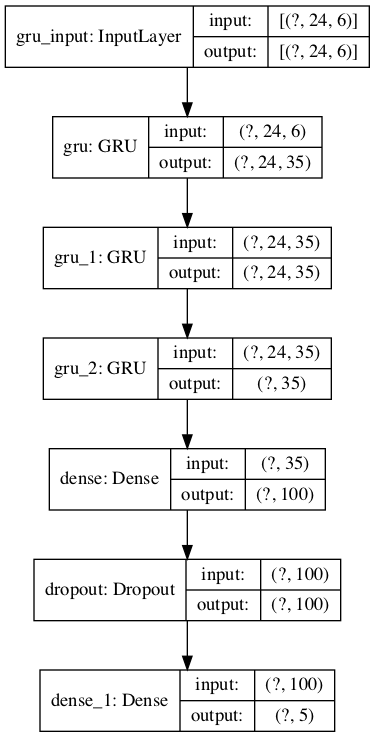

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='gru_model.png', show_shapes=True)

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=5, restore_best_weights=True)
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    callbacks=[es],
    epochs=50,
)

model.save("gru_model.h5")
joblib.dump(history.history, "gru_model.history")

Train on 145950 samples, validate on 48651 samples
Epoch 1/50
 31936/145950 [=====>........................] - ETA: 3:06 - loss: 8.1076WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

In [8]:
history = joblib.load("dannowitz_jlab2_model_20191031.history")

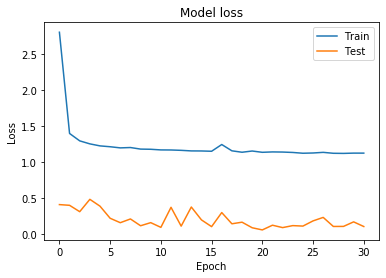

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Calculate the score on my predictions

* Scoring code provided by Thomas Britton
* Each kinematic has different weight

In [42]:
pred = pd.read_csv('data/submission/dannowitz_jlab2_submission_20191112.csv', header=None)
truth = pd.read_csv('data/ANSWERS.csv', header=None)

In [43]:
# Calculate square root of the mean squared error
# Then apply weights and sum them all up
sq_error = (truth - pred).applymap(np.square)
mse = sq_error.sum() / len(truth)
rmse = np.sqrt(mse)
rms_weighted = rmse / [0.03, 0.03, 0.01, 0.01, 0.011]
score = rms_weighted.sum()
score

72.17822893581052

## Visualize the predictions vs true

You can slice and dice the stats however you want, but it helps to be able to see your predictions at work.

# Running history of me tinkering around

* I didn't arrive at this construction from the start.
* Many different changes and tweaks 

In [161]:
def lstm_model():
    
    model = Sequential()
    model.add(LSTM(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [150]:
model = lstm_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 200)               165600    
_________________________________________________________________
dense_17 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 505       
Total params: 186,205
Trainable params: 186,205
Non-trainable params: 0
_________________________________________________________________


In [143]:
history = model.fit(x=X_train_array, y=y_train_array, validation_data=(X_test_array, y_test_array), epochs=5)

Train on 194601 samples, validate on 10000 samples
Epoch 1/5
194601/194601 [==============================] - 259s 1ms/sample - loss: 116.3854 - val_loss: 5.4352
Epoch 2/5
194601/194601 [==============================] - 233s 1ms/sample - loss: 1.8483 - val_loss: 3.8398
Epoch 3/5
194601/194601 [==============================] - 206s 1ms/sample - loss: 0.6441 - val_loss: 0.2240
Epoch 4/5
194601/194601 [==============================] - 248s 1ms/sample - loss: 0.2546 - val_loss: 0.1212
Epoch 5/5
194601/194601 [==============================] - 252s 1ms/sample - loss: 0.1832 - val_loss: 0.1357


In [151]:
history = model.fit(x=X_train_array, y=y_train_array,
                    validation_data=(X_test_array, y_test_array),
                    epochs=50, use_multiprocessing=True)

Train on 194601 samples, validate on 10000 samples
Epoch 1/50
194601/194601 [==============================] - 218s 1ms/sample - loss: 326.7025 - val_loss: 4.9697
Epoch 2/50
194601/194601 [==============================] - 198s 1ms/sample - loss: 4.7569 - val_loss: 1.5031
Epoch 3/50
194601/194601 [==============================] - 192s 989us/sample - loss: 2.2188 - val_loss: 0.7064
Epoch 4/50
194601/194601 [==============================] - 189s 973us/sample - loss: 1.6142 - val_loss: 0.3873
Epoch 5/50
194601/194601 [==============================] - 190s 975us/sample - loss: 1.3676 - val_loss: 0.2826
Epoch 6/50
194601/194601 [==============================] - 190s 977us/sample - loss: 1.2523 - val_loss: 0.2624
Epoch 7/50
194601/194601 [==============================] - 192s 984us/sample - loss: 1.2170 - val_loss: 0.1198
Epoch 8/50
194601/194601 [==============================] - 191s 984us/sample - loss: 1.1980 - val_loss: 0.3450
Epoch 9/50
194601/194601 [=============================

In [156]:
model = lstm_model()
es = EarlyStopping(monitor='val_loss', mode='min')
history = model.fit(x=X_train_array, y=y_train_array,
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 194601 samples, validate on 10000 samples
Epoch 1/20
194601/194601 [==============================] - 198s 1ms/sample - loss: 249.5579 - val_loss: 0.7746
Epoch 2/20
194601/194601 [==============================] - 2346s 12ms/sample - loss: 2.5781 - val_loss: 0.6244
Epoch 3/20
194601/194601 [==============================] - 202s 1ms/sample - loss: 1.7952 - val_loss: 0.3346
Epoch 4/20
194601/194601 [==============================] - 195s 1ms/sample - loss: 1.3872 - val_loss: 0.1804
Epoch 5/20
194601/194601 [==============================] - 196s 1ms/sample - loss: 1.2802 - val_loss: 0.1384
Epoch 6/20
194601/194601 [==============================] - 195s 1ms/sample - loss: 1.2745 - val_loss: 0.2104


In [157]:
model.save("lstm100-dense100-dropout025-epochs20-early-stopping.h5")

In [162]:
def lstm_model_lin():
    
    model = Sequential()
    model.add(LSTM(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1, activation='linear'))
    model.compile(loss='mse', optimizer='adam')
    
    return model

lin_act_model = lstm_model_lin()
es = EarlyStopping(monitor='val_loss', mode='min')
history = lin_act_model.fit(x=X_train_array[:10000], y=y_train_array[:10000],
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 16s 2ms/sample - loss: 722.3176 - val_loss: 23.1267
Epoch 2/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 25.8648 - val_loss: 9.7359
Epoch 3/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 13.8674 - val_loss: 4.2730
Epoch 4/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 9.6217 - val_loss: 2.6301
Epoch 5/20
10000/10000 [==============================] - 16s 2ms/sample - loss: 7.4191 - val_loss: 1.9886
Epoch 6/20
10000/10000 [==============================] - 15s 1ms/sample - loss: 6.2753 - val_loss: 2.1294


In [164]:
def lstm_model_adam():
    
    model = Sequential()
    model.add(LSTM(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

adam_model = lstm_model_adam()
es = EarlyStopping(monitor='val_loss', mode='min')
history = adam_model.fit(x=X_train_array[:10000], y=y_train_array[:10000],
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 14s 1ms/sample - loss: 305.4409 - val_loss: 16.1725
Epoch 2/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 19.2072 - val_loss: 6.6038
Epoch 3/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 10.8057 - val_loss: 4.2676
Epoch 4/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 7.9416 - val_loss: 2.1789
Epoch 5/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 6.2256 - val_loss: 2.3635


In [166]:
def lstm_model_dropout50():
    
    model = Sequential()
    model.add(LSTM(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.50))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

dropout50_model = lstm_model_dropout50()
es = EarlyStopping(monitor='val_loss', mode='min')
history = dropout50_model.fit(x=X_train_array[:10000], y=y_train_array[:10000],
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 14s 1ms/sample - loss: 2095.8651 - val_loss: 253.8501
Epoch 2/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 305.1297 - val_loss: 85.6102
Epoch 3/20
10000/10000 [==============================] - 14s 1ms/sample - loss: 143.2311 - val_loss: 64.7771
Epoch 4/20
10000/10000 [==============================] - 15s 1ms/sample - loss: 66.5812 - val_loss: 36.7483
Epoch 5/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 45.9202 - val_loss: 25.6323
Epoch 6/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 35.9694 - val_loss: 19.3018
Epoch 7/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 30.0887 - val_loss: 16.9329
Epoch 8/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 25.2751 - val_loss: 12.3551
Epoch 9/20
10000/10000 [==============================] - 13s 1ms/sample 

In [172]:
def lstm_model_nodropout():
    
    model = Sequential()
    model.add(LSTM(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

nodropout_model = lstm_model_nodropout()
es = EarlyStopping(monitor='val_loss', mode='min')
history = nodropout_model.fit(x=X_train_array[:10000], y=y_train_array[:10000],
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 14s 1ms/sample - loss: 303.2399 - val_loss: 28.9260
Epoch 2/20
10000/10000 [==============================] - 12s 1ms/sample - loss: 22.5050 - val_loss: 23.4065
Epoch 3/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 17.9289 - val_loss: 13.7558
Epoch 4/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 12.5689 - val_loss: 9.9349
Epoch 5/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 9.5144 - val_loss: 8.0810
Epoch 6/20
10000/10000 [==============================] - 12s 1ms/sample - loss: 8.5819 - val_loss: 8.3551


In [167]:
def lstm_model_relu():
    
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

relu_model = lstm_model_relu()
es = EarlyStopping(monitor='val_loss', mode='min')
history = relu_model.fit(x=X_train_array[:10000], y=y_train_array[:10000],
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 14s 1ms/sample - loss: 187.4669 - val_loss: 17.1837
Epoch 2/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 20.4060 - val_loss: 5.7464
Epoch 3/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 12.9890 - val_loss: 2.9215
Epoch 4/20
10000/10000 [==============================] - 12s 1ms/sample - loss: 10.3698 - val_loss: 3.3642


In [170]:
def model_gru():
    
    model = Sequential()
    model.add(GRU(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

gru_model = model_gru()
es = EarlyStopping(monitor='val_loss', mode='min')
history = gru_model.fit(x=X_train_array[:10000], y=y_train_array[:10000],
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 14s 1ms/sample - loss: 15.1533 - val_loss: 0.9619
Epoch 2/20
10000/10000 [==============================] - 12s 1ms/sample - loss: 3.2930 - val_loss: 0.6037
Epoch 3/20
10000/10000 [==============================] - 12s 1ms/sample - loss: 2.6465 - val_loss: 0.8654


### Early Conclusions

* GRU > LSTM
* LeakyReLU > ReLU
* adam > rmsprop
* dropout 0.25 > dropout 0.5 > no dropout

In [243]:
def model_v2():
    
    model = Sequential()
    model.add(GRU(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

v2_model = model_v2()
es = EarlyStopping(monitor='val_loss', mode='min')
history = v2_model.fit(x=X_train_array, y=y_train_array,
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=8, use_multiprocessing=True)

Train on 194601 samples, validate on 10000 samples
Epoch 1/8
194601/194601 [==============================] - 208s 1ms/sample - loss: 2.3328 - val_loss: 0.3510
Epoch 2/8
194601/194601 [==============================] - 202s 1ms/sample - loss: 1.3041 - val_loss: 0.1264
Epoch 3/8
194601/194601 [==============================] - 204s 1ms/sample - loss: 1.2133 - val_loss: 0.2112


In [ ]:
from tensorflow.keras.back

In [26]:
def model_v2_deep():
    
    model = Sequential()
    model.add(GRU(30, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS),
                  return_sequences=True))
    model.add(GRU(30, activation=LeakyReLU(), return_sequences=True))
    model.add(GRU(30, activation=LeakyReLU()))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

v2_model_deep = model_v2_deep()
v2_model_deep.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 24, 30)            3420      
_________________________________________________________________
gru_8 (GRU)                  (None, 24, 30)            5580      
_________________________________________________________________
gru_9 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 18,185
Trainable params: 18,185
Non-trainable params: 0
__________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=2, restore_best_weights=True)
history = v2_model_deep.fit(x=X_train_array, y=y_train_array,
                            validation_data=(X_test_array, y_test_array),
                            callbacks=[es],
                            epochs=8, use_multiprocessing=True)

Train on 194601 samples, validate on 10000 samples
Epoch 1/8
194601/194601 [==============================] - 304s 2ms/sample - loss: 2.8970 - val_loss: 0.4792
Epoch 2/8
194601/194601 [==============================] - 290s 1ms/sample - loss: 1.5549 - val_loss: 0.5346
Epoch 3/8
194601/194601 [==============================] - 281s 1ms/sample - loss: 1.3498 - val_loss: 0.3451
Epoch 4/8
194601/194601 [==============================] - 275s 1ms/sample - loss: 1.4204 - val_loss: 0.4317
Epoch 5/8
194601/194601 [==============================] - 289s 1ms/sample - loss: 1.3467 - val_loss: 0.2232
Epoch 6/8
194601/194601 [==============================] - 268s 1ms/sample - loss: 1.2464 - val_loss: 0.1453
Epoch 7/8
194601/194601 [==============================] - 279s 1ms/sample - loss: 1.2127 - val_loss: 0.1390
Epoch 8/8
158144/194601 [=======================>......] - ETA: 55s - loss: 1.1842

In [242]:
def model_v2_dbl_gru():
    
    model = Sequential()
    model.add(GRU(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS),
                  return_sequences=True))
    model.add(GRU(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

v2_model_dbl_gru = model_v2_dbl_gru()
es = EarlyStopping(monitor='val_loss', mode='min')
history = v2_model_dbl_gru.fit(x=X_train_array[:20000], y=y_train_array[:20000],
                    validation_data=(X_test_array, y_test_array),
                    #callbacks=[es],
                    epochs=10, use_multiprocessing=True)

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 55s 3ms/sample - loss: 6.2944 - val_loss: 0.8832
Epoch 2/10
20000/20000 [==============================] - 50s 3ms/sample - loss: 2.3380 - val_loss: 0.8004
Epoch 3/10
20000/20000 [==============================] - 49s 2ms/sample - loss: 1.9149 - val_loss: 0.6378
Epoch 4/10
20000/20000 [==============================] - 50s 3ms/sample - loss: 1.8121 - val_loss: 0.4890
Epoch 5/10
20000/20000 [==============================] - 52s 3ms/sample - loss: 1.7023 - val_loss: 0.4793
Epoch 6/10
20000/20000 [==============================] - 50s 2ms/sample - loss: 1.7116 - val_loss: 0.5745
Epoch 7/10
20000/20000 [==============================] - 51s 3ms/sample - loss: 1.7073 - val_loss: 0.4136
Epoch 8/10
20000/20000 [==============================] - 51s 3ms/sample - loss: 1.6392 - val_loss: 0.6285
Epoch 9/10
20000/20000 [==============================] - 50s 2ms/sample - loss: 1.6129 - val_

In [177]:
def model_v2_2x_dropout():
    
    model = Sequential()
    model.add(GRU(200, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

v2_model_dbl_dropout = model_v2_2x_dropout()
es = EarlyStopping(monitor='val_loss', mode='min')
history = v2_model_dbl_dropout.fit(x=X_train_array[:20000], y=y_train_array[:20000],
                    validation_data=(X_test_array, y_test_array),
                    callbacks=[es], epochs=20, use_multiprocessing=True)

Train on 20000 samples, validate on 10000 samples
Epoch 1/20
20000/20000 [==============================] - 24s 1ms/sample - loss: 18.9925 - val_loss: 2.0618
Epoch 2/20
20000/20000 [==============================] - 22s 1ms/sample - loss: 4.9002 - val_loss: 1.2547
Epoch 3/20
20000/20000 [==============================] - 22s 1ms/sample - loss: 3.7768 - val_loss: 0.6070
Epoch 4/20
20000/20000 [==============================] - 22s 1ms/sample - loss: 3.2649 - val_loss: 1.2479


In [200]:
def model_v2_big_gru():
    
    model = Sequential()
    model.add(GRU(400, activation=LeakyReLU(), input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

v2_model_big_gru = model_v2_big_gru()
es = EarlyStopping(monitor='val_loss', mode='min')
history = v2_model_big_gru.fit(x=X_train_array[:20000], y=y_train_array[:20000],
                    validation_data=(X_test_array, y_test_array),
                    #callbacks=[es],
                    epochs=10, use_multiprocessing=True)

ValueError: Input 0 of layer gru_14 is incompatible with the layer: expected ndim=3, found ndim=5. Full shape received: [None, 1, None, 24, 6]

In [181]:
v2_model_big_gru.fit(x=X_train_array[:20000], y=y_train_array[:20000],
                    validation_data=(X_test_array, y_test_array),
                    #callbacks=[es],
                    epochs=15, use_multiprocessing=True, initial_epoch=10)

Train on 20000 samples, validate on 10000 samples
Epoch 11/15
20000/20000 [==============================] - 54s 3ms/sample - loss: 1.3613 - val_loss: 0.5861
Epoch 12/15
20000/20000 [==============================] - 55s 3ms/sample - loss: 1.3655 - val_loss: 0.2373
Epoch 13/15
20000/20000 [==============================] - 54s 3ms/sample - loss: 1.2724 - val_loss: 0.1703
Epoch 14/15
20000/20000 [==============================] - 54s 3ms/sample - loss: 1.2940 - val_loss: 0.3137
Epoch 15/15
20000/20000 [==============================] - 54s 3ms/sample - loss: 1.2810 - val_loss: 0.1698


## Try CNN LSTM

In [221]:
X_train_array.shape

(194601, 24, 6)

In [240]:
def cnn_gru():
    
    model = Sequential()
    model.add(Conv1D(filters=5, kernel_size=2, strides=1, input_shape=(N_DETECTORS-1, N_KINEMATICS)))
    #model.add(MaxPooling1D())
    model.add(GRU(200, activation=LeakyReLU()))
    model.add(Dense(100, activation=LeakyReLU()))
    model.add(Dropout(0.25))
    model.add(Dense(N_KINEMATICS-1))
    model.compile(loss='mse', optimizer='adam')
    
    return model

cnn_model = cnn_gru()
cnn_model.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 23, 5)             65        
_________________________________________________________________
gru_25 (GRU)                 (None, 200)               124200    
_________________________________________________________________
dense_69 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 5)                 505       
Total params: 144,870
Trainable params: 144,870
Non-trainable params: 0
_________________________________________________________________


In [241]:
#es = EarlyStopping(monitor='val_loss', mode='min')
history = cnn_model.fit(x=X_train_array[:20000], y=y_train_array[:20000],
                      validation_data=(X_test_array, y_test_array),
                      epochs=10, use_multiprocessing=True)

Train on 20000 samples, validate on 10000 samples
Epoch 1/10
20000/20000 [==============================] - 23s 1ms/sample - loss: 13.3734 - val_loss: 1.6757
Epoch 2/10
20000/20000 [==============================] - 22s 1ms/sample - loss: 3.0693 - val_loss: 0.8470
Epoch 3/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 2.6314 - val_loss: 0.7303
Epoch 4/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 2.1451 - val_loss: 0.8053
Epoch 5/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 2.0921 - val_loss: 0.7273
Epoch 6/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 1.9285 - val_loss: 0.4551
Epoch 7/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 1.8432 - val_loss: 0.6966
Epoch 8/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 1.6800 - val_loss: 0.5120
Epoch 9/10
20000/20000 [==============================] - 21s 1ms/sample - loss: 1.5675 - val

In [251]:
history.history

{'loss': [3.3281039200901317,
  1.6039592637484563,
  1.3489888134789536,
  1.2624885631565317,
  1.2353142021468715,
  1.211998767219029,
  1.1837373140878185,
  1.1759768705626037],
 'val_loss': [0.778679012966156,
  0.5407980192184448,
  0.5594191231250762,
  0.4179811120986939,
  0.27897539434432983,
  0.18599163811206817,
  0.1257927789211273,
  0.10037544323205948]}

## Enough tinkering around

* Formalize this into some scripts
* Make predictions on competition test data

In [1]:
from train import train
from predict import predict

In [2]:
model = train(frac=1.00, filename="dannowitz_jlab2_model", epochs=100, ret_model=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24, 30)            3420      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24, 30)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 30)            5580      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 30)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                5580      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

KeyboardInterrupt: 

In [ ]:
preds = predict(model_filename="dannowitz_jlab2_model.h5",
                data_filename="test_in (1).csv",
                output_filename="danowitz_jlab2_submission.csv")